# News Sentiment and Time Series ML with Crypto

In [1]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import nltk
from textblob import TextBlob
import numpy as np
import random
import plotly.express as px
from prophet import Prophet

# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

# News Data

In [2]:
def getNews(ticker, days):
    """
    Retrieves financial news over the course of a specified number of days for
    a given stock ticker.
    """

    # List of news
    news = []
    
    # How many days back to retrieve
    ago = datetime.now() - timedelta(days=days)

    # Getting news over the course of a year
    for i in tqdm(range(20, days, 20)):
        
        # The date range to gather news
        date_range = [
            (ago+timedelta(days=i-20)).strftime("%Y-%m-%d"),
            (ago+timedelta(days=i)).strftime("%Y-%m-%d")
        ]

        # Grabbing the news
        resp = client.get_financial_news(
            s=ticker+".CC",
            from_=date_range[0],
            to=date_range[1],
            limit=100
        )

        # Adding to the news list
        news.extend(resp)
        
    # Full names of given cryptos (for the top cryptos right now)
    cc_name = {
        "btc": "bitcoin",
        "eth": "ethereum",
        "bnb": "binance",
        "usdt": "tether",
        "sol": "solana"
    }
    
    if ticker.lower() in cc_name:
        full_cc = cc_name[ticker.lower()]
    else:
        full_cc = None
                
    # Filtering out irrelevant news
    lst = [
        i for i in news if sum(x in {ticker.lower(), full_cc} for x in nltk.word_tokenize(i['title'].lower()))>=1
    ]
    
    # Formatting the date
    news = pd.DataFrame(lst)
    
    news['date'] = news['date'].apply(
        lambda x: x[:10]
    )
    
    return news

In [3]:
# Retrieving financial news
news = getNews("BTC", 700)

100%|██████████| 34/34 [00:21<00:00,  1.58it/s]


In [4]:
news

,date,title,content,link,symbols,tags
0,2020-10-22,"MARKETS: Making the case for bitcoin $280,000 ...",Yahoo Finance's Jared Blikre joins Myles Udlan...,https://finance.yahoo.com/video/markets-making...,"[BTC.CC, GSPC.INDX, BTCUSD.FOREX, PG.US, GBTC....",[]
1,2020-12-16,Getting Technical: Breaking down SPY and bitco...,Joining Yahoo Finance's Akiko Fujita and Jared...,https://finance.yahoo.com/video/getting-techni...,"[ETH.CC, BTC.CC, GSPC.INDX, SPY.US, QQQ.US, BC...","[RECORD HIGHS, BRIAN SHANNON, AKIKO FUJITA]"
2,2021-01-07,Bitcoin hits $40k: Pantera Capital CEO on cryp...,Pantera Capital CEO Dan Morehead joined Yahoo ...,https://finance.yahoo.com/video/bitcoin-narrat...,"[ETH.CC, BTC.CC, BTCUSD.FOREX, LTC.US, ETHUSD....","[BITCOIN, DAN MOREHEAD, PRICE OF BITCOIN, DAN ..."
3,2021-01-07,Bitcoin hits $40k: Pantera Capital CEO on cryp...,Pantera Capital CEO Dan Morehead joined Yahoo ...,https://finance.yahoo.com/video/bitcoin-narrat...,"[ETH.CC, BTC.CC, BTCUSD.FOREX, LTC.US, ETHUSD....","[BITCOIN, DAN MOREHEAD, PRICE OF BITCOIN, DAN ..."
4,2020-12-23,The price of bitcoin is 'driven by manipulatio...,"Nouriel Roubini, professor of economics at New...",https://finance.yahoo.com/video/price-bitcoin-...,"[BTC.CC, GSPC.INDX, BTCUSD.FOREX, EEM.US]","[JULIA LA ROCHE, NOURIEL ROUBINI]"
...,...,...,...,...,...,...
646,2021-12-10,Bitcoin (BTC) Creates Bearish Candlestick Afte...,BeInCrypto –\n\nBitcoin (BTC) has reached the ...,https://finance.yahoo.com/news/bitcoin-btc-cre...,"[BTC-USD.CC, BTC.CC]","[BITCOIN, TELEGRAM GROUP]"
647,2021-12-10,Bitcoin Failed as a Productive Asset and Maxim...,"BeInCrypto –\n\nMuneeb Ali, the founder of Sta...",https://finance.yahoo.com/news/bitcoin-failed-...,"[BTC-USD.CC, BTC.CC]","[BITCOIN, CRYPTOCURRENCY, STACKS, TELEGRAM GRO..."
648,2021-12-10,"Bitcoin (BTC) – A Return to $50,000 Would Supp...",This is the tech analysis for Bitcoin. We will...,https://finance.yahoo.com/news/bitcoin-btc-ret...,"[BTC-GBP.US, BTC-CAD.US, BTC-INR.US, BTC-AUD.U...",[BITCOIN]
649,2021-12-09,First Mover Asia: Bitcoin Falls Below $49K as ...,Good morning. Here’s what’s happening this mor...,https://finance.yahoo.com/news/first-mover-asi...,"[BTC-USD.CC, ETH.CC, BTC.CC, ETH-USD.CC]","[BITCOIN, COINDESK, BITCOIN PRICES, CONSUMER P..."


# Sentiment Analysis on News

In [5]:
def sentimentPositions(val, thresh=0.1, short=True):
    """
    Returns position as 1, -1, or 0 for Buy, Sell, 
    and Do Nothing respectively based on the given 
    sentiment value and threshold.
    """
    if val > thresh:
        return 1
    elif val < -thresh and short:
        return -1
    else:
        return 0

In [6]:
# Getting sentiment values for the news headlines/titles
news['sentiment'] = news['title'].apply(
    lambda x: TextBlob(x.lower()).sentiment[0]
)

# Grouping together dates and aggregating sentiment scores from the same day
sent_df = news.groupby('date')[['sentiment']].median()

# Applying the position function
sent_df['sentiment_positions'] = sent_df['sentiment'].apply(
    lambda x: sentimentPositions(x, thresh=0.1, short=False)
)

# Filling in missing days with the most recent position value
date_index = [str(i)[:10] for i in pd.date_range(sent_df.index[0], sent_df.index[-1])]

sent_df = sent_df.reindex(date_index).fillna(method='ffill')

In [7]:
print(sent_df['sentiment_positions'].value_counts())
display(sent_df)

0.0    372
1.0     47
Name: sentiment_positions, dtype: int64


,sentiment,sentiment_positions
date,,
2020-10-22,0.0000,0.0
2020-10-23,0.0000,0.0
2020-10-24,0.0000,0.0
2020-10-25,0.0000,0.0
2020-10-26,0.0000,0.0
...,...,...
2021-12-10,0.0000,0.0
2021-12-11,0.0000,0.0
2021-12-12,0.1125,1.0


# Price Data

In [8]:
def getPrices(ticker, training_days, sent_df, mov_avg):
    """
    Using a sentiment DataFrame to find the first day and trains with the previous
    N days to make predictions that coincide with the sentiment date range.
    
    In order to properly backtest with sentiment, a certain amount of training 
    days need to come before the initial date from the sentiment DF.
    
    Also prepares the price data for FBProphet.
    """
    # The first day from the sentiment DF minus the amount of days to train with
    ago = datetime.strptime(
        sent_df.index[0], "%Y-%m-%d"
    ) - timedelta(
        days=training_days+mov_avg
    )
    
    # Getting prices
    prices = pd.DataFrame(
        client.get_prices_eod(
            ticker+"-USD.CC", 
            from_=ago.strftime("%Y-%m-%d")
        )
    )

    # Set index
    prices = prices.set_index('date', drop=True)
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['open']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

    # Dropping Nans
    prices.dropna(inplace=True)

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"date": "ds", "MA": "y"}
    )
    
    return prices

In [9]:
prices = getPrices("BTC", 365, sent_df, 5)

prices

,ds,open,high,low,close,adjusted_close,volume,y
0,2019-10-22,8246.3691,8305.6435,8074.3318,8078.6328,8078.6328,13295781020,8106.09
1,2019-10-23,8077.1381,8092.0145,7430.3190,7500.5237,7500.5237,18217163788,8102.14
2,2019-10-24,7501.9340,7549.9211,7428.8707,7498.1919,7498.1919,13543154964,8008.75
3,2019-10-25,7493.0171,8700.2281,7481.1316,8664.0857,8664.0857,23014040629,7910.97
4,2019-10-26,8673.3812,10121.1993,8672.9980,9249.0335,9249.0335,35921139659,7998.37
...,...,...,...,...,...,...,...,...
800,2021-12-30,46622.1672,47903.1183,46378.8780,47171.7451,47171.7451,28126706190,49311.54
801,2021-12-31,47183.1404,48511.4483,45916.6218,46387.9753,46387.9753,33178512425,48629.57
802,2022-01-01,46297.9006,47833.4851,46297.9006,47669.4280,47669.4280,22429490367,47714.93
803,2022-01-02,47736.6104,47777.7165,47001.3670,47364.1395,47364.1395,22857776751,47105.25


## Time Series Analysis and Predictions

In [10]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(periods=forecast_period)
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

## Making Predictions over time

In [14]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every N days and gets the 
    price forecasts.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model on each day
    for i in tqdm(range(training_days, len(prices), forecast_period)):

        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_days:i], 
            forecast_period
        ).tail(forecast_period)[[
            'ds',
            'yhat',
            'yhat_lower',
            'yhat_upper'
        ]]

        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Getting the price values from N days ago
    prices['previous_open'] = prices['open'].shift(forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'previous_open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

In [15]:
pred_df = runningFBP(prices, 5, 365)

100%|██████████| 88/88 [00:57<00:00,  1.52it/s]


In [16]:
pred_df

,previous_open,yhat,yhat_lower,yhat_upper
ds,,,,
2020-10-21,11506.3242,11849.609742,11490.321658,12200.133633
2020-10-22,11334.3736,11988.671210,11618.880310,12355.288707
2020-10-23,11375.5256,12120.226184,11773.040143,12489.351307
2020-10-24,11512.2862,12265.338973,11910.267912,12620.782487
2020-10-25,11756.7288,12400.517607,12048.097760,12739.990933
...,...,...,...,...
2021-12-30,50651.1120,54140.980739,51671.160505,56902.589712
2021-12-31,50592.9589,55166.547307,52582.132627,57819.929843
2022-01-01,50871.1362,56223.024192,53579.234598,59045.493099


# Getting Positions
Gets sentiment and time series positions as well as random and buy & hold positions consolidated.

In [17]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['previous_open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['previous_open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

In [18]:
def overallPosition(df):
    """
    Returns the position if both values in the DF are the same.
    Otherwise, the position will be to do nothing.
    """
    if df['sentiment_positions']==df['fbp_positions']:
        return df['sentiment_positions']
    else:
        return 0

## Merging Positions from Sentiment and FB Prophet

In [212]:
# Adding sentiment positions to the forecast DF
positions = pred_df.merge(
    sent_df, 
    right_index=True, 
    left_index=True, 
    how='inner'
)

# Getting forecast positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x), 
    axis=1
)

# Getting the overall positions
positions['overall_positions'] = positions.apply(
    lambda x: overallPosition(x), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

# Random positions
positions['random_positions'] = random.choices(
    [1,0,-1], k=len(positions)
)

positions

,previous_open,yhat,yhat_lower,yhat_upper,sentiment,sentiment_positions,fbp_positions,overall_positions,buy_hold,random_positions
2020-10-22,11334.3736,11989.141372,11633.562881,12344.126558,0.0000,0.0,1,0.0,1,1
2020-10-23,11375.5256,12122.714972,11782.708910,12473.608101,0.0000,0.0,1,0.0,1,1
2020-10-24,11512.2862,12266.075983,11902.699545,12604.637843,0.0000,0.0,1,0.0,1,1
2020-10-25,11756.7288,12389.359381,12035.292095,12739.852494,0.0000,0.0,1,0.0,1,0
2020-10-26,11923.4588,12538.648948,12200.896788,12884.677877,0.0000,0.0,1,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...
2021-12-08,56514.0057,51676.293553,49038.689891,54198.925614,0.0000,0.0,-1,0.0,1,0
2021-12-09,53672.9938,51037.665648,48417.063648,53739.503814,0.0000,0.0,0,0.0,1,1
2021-12-10,49326.8550,49255.634456,46772.558881,51741.983274,0.0000,0.0,0,0.0,1,-1
2021-12-11,49446.4657,48560.179606,45932.572707,51071.884521,0.0000,0.0,0,0.0,1,1


## Returns each Day
Getting the log returns each day for backtesting

In [213]:
# Getting log returns during the time period set by the positions before
log_returns = prices[['ds', 'close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

# Performing the Backtest

In [214]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'overall_positions', 
    'buy_hold', 
    'random_positions',
    'sentiment_positions',
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

In [215]:
# Displaying performance
performance

,overall_positions,buy_hold,random_positions,sentiment_positions,fbp_positions
2020-10-23,1.000000,0.998120,0.998120,1.000000,0.998120
2020-10-24,1.000000,1.012135,1.012135,1.000000,1.012135
2020-10-25,1.000000,1.005852,1.005852,1.000000,1.005852
2020-10-26,1.000000,1.008892,1.005852,1.000000,1.008892
2020-10-27,1.000000,1.053522,1.050348,1.000000,1.053522
...,...,...,...,...,...
2021-12-08,1.021567,3.885415,0.988899,0.820574,1.471174
2021-12-09,1.021567,3.695044,0.988899,0.820574,1.546970
2021-12-10,1.021567,3.656017,0.978454,0.820574,1.546970
2021-12-11,1.021567,3.798646,0.941716,0.820574,1.546970


# Visualizing Backtest Performance

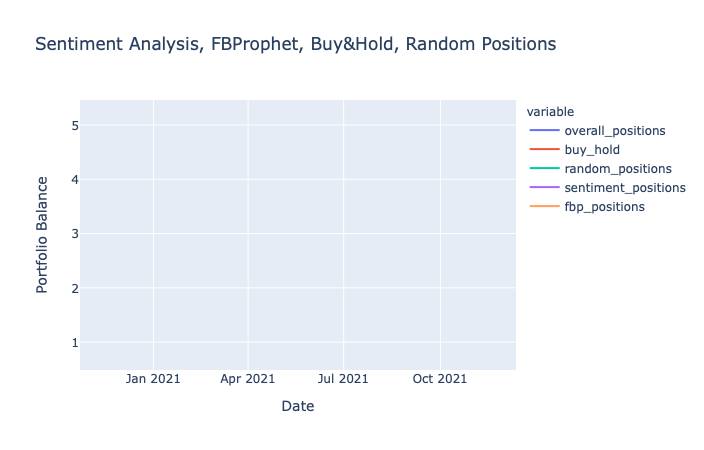

In [216]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Sentiment Analysis, FBProphet, Buy&Hold, Random Positions',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()